# Part 8: Combine Datasets

Combine the datasets and prepare training dataframes

In [1]:
import os
import sys
import datetime
from collections import defaultdict
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import IPython
import sklearn
sklearn.__version__

'0.24.2'

In [2]:
#notebook formatting things
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))
# This changes the width of the coding area
display(HTML("<style>.container { width:95% !important; }</style>"))
# this will make pandas show all columns, using a slider
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 60)

In [3]:
data_dir = "./data"
data_files = [f for f in os.listdir(data_dir) if f.endswith("csv")]
print(data_files)

['google_trends.csv', 'tidy_fred.csv', 'umich_exp.csv', 'us_pau_claims.csv']


In [4]:
origdf = None
for f in data_files:
  print("**{0}".format(f))
  df = pd.read_csv(os.path.join(data_dir, f))
  print("  shape: {0}".format(df.shape))
  print("  df columns: {0}".format(','.join(df.columns)))
  if origdf is None:
    origdf = df
  else:
    origdf = origdf.merge(df, on="date", how="outer", )

origdf['date'] = pd.to_datetime(origdf['date'])

origdf.sort_values(by="date", inplace=True)
origdf.set_index("date", inplace=True)
#print(origdf.shape)
#display(origdf.head(2))

**google_trends.csv
  shape: (600, 29)
  df columns: date,jobs near me hiring,amazon jobs,amazon careers near me,amazon careers,work from home amazon jobs near me,hiring near me part time,amazon jobs work from home,jobs part time near me,amazon near me jobs,amazon near me,jobs near me part time hiring,work from home jobs,job hiring near me,hiring part time near me,part time jobs hiring near me,hiring jobs near me part time,part time jobs hiring,indeed jobs hiring near me,jobs work from home,jobs hiring near me,jobs indeed near me,work from home,jobs near me,indeed jobs,work,work from home amazon,jobs near me hiring part time,jobs
**tidy_fred.csv
  shape: (1049, 18)
  df columns: date,ICSA: Initial Claims,CCSA: Continued Claims ,PAYEMS:Total Nonfarm,USPRIV: BLS private,UNRATE: Unemployment Rate,UNEMPLOY: Unemployment Level,CLF16OV: Civilian Labor Force,UEMP27OV: Unemployed for 27 Weeks,CIVPART: Civilian Participation Rate,JTS1000JOL: Job Openings: Total Private,JTS1000HIL:  Hires: Total

In [5]:
if False:
  import seaborn as sns
  cols = ["PAYEMS:Total Nonfarm","USPRIV: BLS private", 'NPPTTL: ADP']
  corr = origdf[cols].corr()
  sns.set(rc = {'figure.figsize':(22,22)})
  ax = sns.heatmap(
      corr, 
      vmin=-1, vmax=1, center=0,
      cmap=sns.diverging_palette(20, 220, n=200),
      square=True
  )
  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  );

In [6]:
if False:
  #  Show the start, cnt and freq of all the variables
  #   nice to see which are daily, weekly, monthly et cetera
  origdf.notna().sum()
  tups = []
  for col in origdf.columns:
    first_dt = df.loc[origdf[col].notna()].index.min()
    last_dt = origdf.loc[origdf[col].notna()].index.max()  
    days = (last_dt - first_dt).days
    months = days/30.0
    cnt  = origdf.loc[origdf[col].notna()].shape[0]
    obs_per_month = np.round(cnt / (months), 1)
    tups.append((col, first_dt, last_dt, days, months, cnt, obs_per_month))
  x = pd.DataFrame(tups, columns=["col", "first", "last", "days", "months", "cnt", "obs_per_month"])
  x

In [8]:
# set ycol and xclos

data_start_dt =  datetime.datetime(2020, 1,1)

tempdf = origdf.copy()
orig_ycol = [c for c in list(origdf.columns) if c.startswith("PAY")][0]
y_l1 = orig_ycol + "_l1"
nexty = "next_" + orig_ycol
new_ycol = nexty
tempdf[y_l1] =  tempdf[orig_ycol].shift(1)
tempdf[nexty] = tempdf[orig_ycol].shift(-1)
xcols = list(tempdf.columns)
xcols.remove(orig_ycol)
xcols.remove(new_ycol)
tx = xcols
tx.remove(y_l1)
xcols = [y_l1] + tx 
fullx = tempdf[xcols]
fullx = fullx.ffill()

In [10]:

fully = tempdf[[new_ycol]]
newfull = fullx.join(fully)
data_start_dt =  datetime.datetime(2017, 1,1)

newfull = newfull.loc[newfull.index >= data_start_dt]

display(newfull)
#display(newfull.head(16).T.head())
#display(newfull.tail(16).T.head())
#display(newfull.tail(16).T.tail())

,PAYEMS:Total Nonfarm_l1,jobs near me hiring,amazon jobs,amazon careers near me,amazon careers,work from home amazon jobs near me,hiring near me part time,amazon jobs work from home,jobs part time near me,amazon near me jobs,amazon near me,jobs near me part time hiring,work from home jobs,job hiring near me,hiring part time near me,part time jobs hiring near me,hiring jobs near me part time,part time jobs hiring,indeed jobs hiring near me,jobs work from home,jobs hiring near me,jobs indeed near me,work from home,jobs near me,indeed jobs,work,work from home amazon,jobs near me hiring part time,jobs,ICSA: Initial Claims,CCSA: Continued Claims,USPRIV: BLS private,UNRATE: Unemployment Rate,UNEMPLOY: Unemployment Level,CLF16OV: Civilian Labor Force,UEMP27OV: Unemployed for 27 Weeks,CIVPART: Civilian Participation Rate,JTS1000JOL: Job Openings: Total Private,JTS1000HIL: Hires: Total Private,JTS1000TSL: Total Separations: Total Private,NPPTTL: ADP,U6Rate: Unemployed plus Marginally Attached,LNS12032194: Part-Time for Econ Reasons,CSCICP03USM665S: OECD US Consumer Confidence,BSCICP03USM665S: OECD Business Confidence,Personal Finance Expected,Business Condition 12 Months,Business Condition 5 Years,Expected Index,PUA IC,PUA CC,PEUC CC,next_PAYEMS:Total Nonfarm
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,145128.0,49.0,26.0,25.0,47.0,0.0,47.0,3.0,39.0,14.0,18.0,52.0,70.0,76.0,47.0,52.0,52.0,49.0,13.0,70.0,49.0,64.0,71.0,59.0,53.0,90.0,1.0,52.0,87.0,265000.0,2102000.0,122883.0,4.6,7400.0,159486.0,1856.0,62.7,5022.0,4752.0,4557.0,122808.364,9.3,5669.0,100.681100,99.9636,131.0,119.0,110.0,89.5,NaN,NaN,NaN,NaN
2017-01-03,145128.0,49.0,26.0,25.0,47.0,0.0,47.0,3.0,39.0,14.0,18.0,52.0,70.0,76.0,47.0,52.0,52.0,49.0,13.0,70.0,49.0,64.0,71.0,59.0,53.0,90.0,1.0,52.0,87.0,265000.0,2102000.0,122883.0,4.6,7400.0,159486.0,1856.0,62.7,5022.0,4752.0,4557.0,122808.364,9.3,5669.0,101.287600,100.2981,131.0,119.0,110.0,89.5,NaN,NaN,NaN,NaN
2017-01-05,145128.0,49.0,26.0,25.0,47.0,0.0,47.0,3.0,39.0,14.0,18.0,52.0,70.0,76.0,47.0,52.0,52.0,49.0,13.0,70.0,49.0,64.0,71.0,59.0,53.0,90.0,1.0,52.0,87.0,235000.0,2112000.0,122883.0,4.6,7400.0,159486.0,1856.0,62.7,5022.0,4752.0,4557.0,122965.275,9.3,5669.0,101.287600,100.2981,131.0,119.0,110.0,89.5,NaN,NaN,NaN,145303.0
2017-01-06,145128.0,49.0,26.0,25.0,47.0,0.0,47.0,3.0,39.0,14.0,18.0,52.0,70.0,76.0,47.0,52.0,52.0,49.0,13.0,70.0,49.0,64.0,71.0,59.0,53.0,90.0,1.0,52.0,87.0,235000.0,2112000.0,123080.0,4.7,7529.0,159640.0,1831.0,62.7,5022.0,4752.0,4557.0,122965.275,9.2,5598.0,101.287600,100.2981,131.0,119.0,110.0,89.5,NaN,NaN,NaN,NaN
2017-01-08,145303.0,51.0,45.0,0.0,68.0,0.0,61.0,3.0,52.0,20.0,12.0,54.0,66.0,88.0,61.0,54.0,54.0,67.0,0.0,66.0,51.0,8.0,71.0,61.0,55.0,93.0,9.0,54.0,91.0,235000.0,2112000.0,123080.0,4.7,7529.0,159640.0,1831.0,62.7,5022.0,4752.0,4557.0,122965.275,9.2,5598.0,101.287600,100.2981,131.0,119.0,110.0,89.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-16,147553.0,76.0,45.0,51.0,43.0,63.0,50.0,27.0,60.0,52.0,41.0,48.0,57.0,54.0,50.0,48.0,48.0,46.0,41.0,57.0,76.0,98.0,59.0,87.0,92.0,77.0,17.0,48.0,72.0,293000.0,2593000.0,125569.0,4.8,7674.0,161354.0,2683.0,61.6,9603.0,6008.0,5712.0,123853.888,8.5,4468.0,97.704797,101.7605,112.0,84.0,76.0,68.1,2565.0,270013.0,244379.0,NaN
2021-10-17,147553.0,75.0,54.0,25.0,55.0,84.0,44.0,26.0,57.0,57.0,44.0,43.0,70.0,65.0,44.0,43.0,43.0,39.0,53.0,70.0,75.0,73.0,63.0,89.0,90.0,71.0,24.0,43.0,72.0,293000.0,2593000.0,125569.0,4.8,7674.0,161354.0,2683.0,61.6,9603.0,6008.0,5712.0,123853.888,8.5,4468.0,97.704797,101.7605,112.0,84.0,76.0,68.1,2565.0,270013.0,244379.0,NaN
2021-10-21,147553.0,75.0,54.0,25.0,55.0,84.0,44.0,26.0,57.0,57.0,44.0,43.0,70.0,65.0,44.0,43.0,43.0,39.0,53.0,70.0,75.0,73.0,63.0,89.0,90.0,71.0,24.0,43.0,72.0,290000.0,2481000.0,125569.0,4.8,767

## Construct prediction matrices

First, make a dataframe with target and predictors
Will add a lagged predictor.
Have to be careful not to use any predictors that would only have been known when the target is known

So, we will only use X values where date is one day before Y value was known

In [11]:
ycol = nexty
xmat = newfull[xcols].ffill()
print(xmat.shape)

(811, 52)


In [14]:
# fill na with 0 for any that still have na
z = xmat.isna().sum()
ncols = list(z.loc[xmat.isna().sum() > 0].index)
xmat[ncols] = xmat[ncols].fillna(method="backfill")

ymat = pd.concat([newfull[[ycol]].loc[newfull[ycol].notna()], 
                 newfull[[ycol]].tail(1)] )
#ymat = newfull[[ycol]].loc[fulldf[ycol].notna()]
pdf = ymat.join(xmat, how="inner")
print(pdf.shape)
display(pdf.head(1))
display(pdf.tail(2))

(59, 53)


,next_PAYEMS:Total Nonfarm,PAYEMS:Total Nonfarm_l1,jobs near me hiring,amazon jobs,amazon careers near me,amazon careers,work from home amazon jobs near me,hiring near me part time,amazon jobs work from home,jobs part time near me,amazon near me jobs,amazon near me,jobs near me part time hiring,work from home jobs,job hiring near me,hiring part time near me,part time jobs hiring near me,hiring jobs near me part time,part time jobs hiring,indeed jobs hiring near me,jobs work from home,jobs hiring near me,jobs indeed near me,work from home,jobs near me,indeed jobs,work,work from home amazon,jobs near me hiring part time,jobs,ICSA: Initial Claims,CCSA: Continued Claims,USPRIV: BLS private,UNRATE: Unemployment Rate,UNEMPLOY: Unemployment Level,CLF16OV: Civilian Labor Force,UEMP27OV: Unemployed for 27 Weeks,CIVPART: Civilian Participation Rate,JTS1000JOL: Job Openings: Total Private,JTS1000HIL: Hires: Total Private,JTS1000TSL: Total Separations: Total Private,NPPTTL: ADP,U6Rate: Unemployed plus Marginally Attached,LNS12032194: Part-Time for Econ Reasons,CSCICP03USM665S: OECD US Consumer Confidence,BSCICP03USM665S: OECD Business Confidence,Personal Finance Expected,Business Condition 12 Months,Business Condition 5 Years,Expected Index,PUA IC,PUA CC,PEUC CC
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-05,145303.0,145128.0,49.0,26.0,25.0,47.0,0.0,47.0,3.0,39.0,14.0,18.0,52.0,70.0,76.0,47.0,52.0,52.0,49.0,13.0,70.0,49.0,64.0,71.0,59.0,53.0,90.0,1.0,52.0,87.0,235000.0,2112000.0,122883.0,4.6,7400.0,159486.0,1856.0,62.7,5022.0,4752.0,4557.0,122965.275,9.3,5669.0,101.2876,100.2981,131.0,119.0,110.0,89.5,32078.0,66941.0,1896.0


,next_PAYEMS:Total Nonfarm,PAYEMS:Total Nonfarm_l1,jobs near me hiring,amazon jobs,amazon careers near me,amazon careers,work from home amazon jobs near me,hiring near me part time,amazon jobs work from home,jobs part time near me,amazon near me jobs,amazon near me,jobs near me part time hiring,work from home jobs,job hiring near me,hiring part time near me,part time jobs hiring near me,hiring jobs near me part time,part time jobs hiring,indeed jobs hiring near me,jobs work from home,jobs hiring near me,jobs indeed near me,work from home,jobs near me,indeed jobs,work,work from home amazon,jobs near me hiring part time,jobs,ICSA: Initial Claims,CCSA: Continued Claims,USPRIV: BLS private,UNRATE: Unemployment Rate,UNEMPLOY: Unemployment Level,CLF16OV: Civilian Labor Force,UEMP27OV: Unemployed for 27 Weeks,CIVPART: Civilian Participation Rate,JTS1000JOL: Job Openings: Total Private,JTS1000HIL: Hires: Total Private,JTS1000TSL: Total Separations: Total Private,NPPTTL: ADP,U6Rate: Unemployed plus Marginally Attached,LNS12032194: Part-Time for Econ Reasons,CSCICP03USM665S: OECD US Consumer Confidence,BSCICP03USM665S: OECD Business Confidence,Personal Finance Expected,Business Condition 12 Months,Business Condition 5 Years,Expected Index,PUA IC,PUA CC,PEUC CC
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-07,147553.0,147190.0,67.0,40.0,25.0,40.0,62.0,53.0,18.0,61.0,54.0,41.0,54.0,62.0,64.0,53.0,54.0,54.0,41.0,47.0,62.0,67.0,94.0,60.0,89.0,94.0,75.0,21.0,54.0,75.0,326000.0,2714000.0,125145.0,5.2,8384.0,161537.0,3179.0,61.7,9881.0,6166.0,5515.0,123853.888,8.8,4469.0,99.344356,101.501996,112.0,84.0,76.0,68.1,22993.0,549103.0,440435.0
2021-10-28,NaN,147553.0,71.0,50.0,8.0,42.0,0.0,40.0,13.0,57.0,42.0,41.0,52.0,64.0,42.0,40.0,52.0,52.0,38.0,52.0,64.0,71.0,88.0,62.0,82.0,90.0,72.0,30.0,52.0,72.0,281000.0,2243000.0,125569.0,4.8,7674.0,161354.0,2683.0,61.6,9603.0,6008.0,5712.0,123853.888,8.5,4468.0,97.704797,101.760500,112.0,84.0,76.0,68.1,2565.0,270013.0,244379.0


In [15]:
pdf.corr()
if False:
  import seaborn as sns
  cols = ["PAYEMS:Total Nonfarm","USPRIV: BLS private", 'NPPTTL: ADP']
  # methods: 'pearson', 'kendall', 'spearman'
  corr = pdf.corr(method = 'kendall')
  sns.set(rc = {'figure.figsize':(16,16)})
  ax = sns.heatmap(
      corr, 
      vmin=-1, vmax=1, center=0,
      cmap=sns.diverging_palette(20, 220, n=200),
      square=True
  )
  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  );

In [16]:
if False:
  pcols = [ycol, "last_PAYEMS:Total Nonfarm","USPRIV: BLS private", 'NPPTTL: ADP']
  inds = np.logical_and(pdf.index > datetime.datetime(2019, 4, 1),
                         pdf.index < datetime.datetime(2021, 12, 1))
  pdf.loc[inds, pcols].plot(figsize=[24,6], grid=True, marker='o')

In [17]:
diffdf = pdf.diff(1).copy()
#diffdf.fillna(0, inplace=True)
diffdf = diffdf.loc[diffdf.index > diffdf.index[0]]
display(diffdf.head(2))
display(diffdf.tail(2))

,next_PAYEMS:Total Nonfarm,PAYEMS:Total Nonfarm_l1,jobs near me hiring,amazon jobs,amazon careers near me,amazon careers,work from home amazon jobs near me,hiring near me part time,amazon jobs work from home,jobs part time near me,amazon near me jobs,amazon near me,jobs near me part time hiring,work from home jobs,job hiring near me,hiring part time near me,part time jobs hiring near me,hiring jobs near me part time,part time jobs hiring,indeed jobs hiring near me,jobs work from home,jobs hiring near me,jobs indeed near me,work from home,jobs near me,indeed jobs,work,work from home amazon,jobs near me hiring part time,jobs,ICSA: Initial Claims,CCSA: Continued Claims,USPRIV: BLS private,UNRATE: Unemployment Rate,UNEMPLOY: Unemployment Level,CLF16OV: Civilian Labor Force,UEMP27OV: Unemployed for 27 Weeks,CIVPART: Civilian Participation Rate,JTS1000JOL: Job Openings: Total Private,JTS1000HIL: Hires: Total Private,JTS1000TSL: Total Separations: Total Private,NPPTTL: ADP,U6Rate: Unemployed plus Marginally Attached,LNS12032194: Part-Time for Econ Reasons,CSCICP03USM665S: OECD US Consumer Confidence,BSCICP03USM665S: OECD Business Confidence,Personal Finance Expected,Business Condition 12 Months,Business Condition 5 Years,Expected Index,PUA IC,PUA CC,PEUC CC
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-02-02,251.0,175.0,6.0,1.0,-25.0,-4.0,0.0,-7.0,1.0,10.0,25.0,15.0,4.0,-15.0,-2.0,-7.0,4.0,4.0,22.0,23.0,-15.0,6.0,-25.0,-26.0,-10.0,-5.0,-1.0,4.0,4.0,-1.0,11000.0,-48000.0,197.0,0.1,129.0,154.0,-25.0,0.0,-50.0,96.0,125.0,255.821,-0.1,-71.0,0.2170,0.3060,-1.0,2.0,2.0,0.8,0.0,0.0,0.0
2017-03-09,244.0,251.0,-17.0,-5.0,0.0,-6.0,0.0,20.0,1.0,-16.0,-27.0,-22.0,-34.0,-4.0,-23.0,20.0,-34.0,-34.0,-10.0,-13.0,-4.0,-17.0,18.0,6.0,2.0,7.0,-2.0,-3.0,-34.0,-5.0,-3000.0,-6000.0,198.0,0.1,106.0,76.0,19.0,0.2,45.0,83.0,-23.0,345.451,0.2,242.0,-0.1844,0.3489,-7.0,-9.0,0.0,-3.8,0.0,0.0,0.0


,next_PAYEMS:Total Nonfarm,PAYEMS:Total Nonfarm_l1,jobs near me hiring,amazon jobs,amazon careers near me,amazon careers,work from home amazon jobs near me,hiring near me part time,amazon jobs work from home,jobs part time near me,amazon near me jobs,amazon near me,jobs near me part time hiring,work from home jobs,job hiring near me,hiring part time near me,part time jobs hiring near me,hiring jobs near me part time,part time jobs hiring,indeed jobs hiring near me,jobs work from home,jobs hiring near me,jobs indeed near me,work from home,jobs near me,indeed jobs,work,work from home amazon,jobs near me hiring part time,jobs,ICSA: Initial Claims,CCSA: Continued Claims,USPRIV: BLS private,UNRATE: Unemployment Rate,UNEMPLOY: Unemployment Level,CLF16OV: Civilian Labor Force,UEMP27OV: Unemployed for 27 Weeks,CIVPART: Civilian Participation Rate,JTS1000JOL: Job Openings: Total Private,JTS1000HIL: Hires: Total Private,JTS1000TSL: Total Separations: Total Private,NPPTTL: ADP,U6Rate: Unemployed plus Marginally Attached,LNS12032194: Part-Time for Econ Reasons,CSCICP03USM665S: OECD US Consumer Confidence,BSCICP03USM665S: OECD Business Confidence,Personal Finance Expected,Business Condition 12 Months,Business Condition 5 Years,Expected Index,PUA IC,PUA CC,PEUC CC
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-07,363.0,369.0,-3.0,1.0,-32.0,-3.0,42.0,5.0,-3.0,8.0,17.0,3.0,1.0,7.0,17.0,5.0,1.0,1.0,-5.0,-10.0,7.0,-3.0,-6.0,2.0,5.0,0.0,-5.0,7.0,1.0,2.0,-14000.0,-34000.0,377.0,-0.2,-318.0,190.0,-246.0,0.0,727.0,-120.0,204.0,529.595,-0.4,-14.0,0.000000,0.000000,1.0,10.0,1.0,3.0,-79528.0,-4541421.0,-3364573.0
2021-10-28,NaN,363.0,4.0,10.0,-17.0,2.0,-62.0,-13.0,-5.0,-4.0,-12.0,0.0,-2.0,2.0,-22.0,-13.0,-2.0,-2.0,-3.0,5.0,2.0,4.0,-6.0,2.0,-7.0,-4.0,-3.0,9.0,-2.0,-3.0,-45000.0,-471000.0,424.0,-0.4,-710.0,-183.0,-496.0,-0.1,-278.0,-158.0,197.0,0.000,-0.3,-1.0,-1.639559,0.258504,0.0,0.0,0.0,0.0,-20428.0,-279090.0,-196056.0


In [18]:
pdf.corr()
if False:
  import seaborn as sns
  cols = ["PAYEMS:Total Nonfarm","USPRIV: BLS private", 'NPPTTL: ADP']
  # methods: 'pearson', 'kendall', 'spearman'
  corr = diffdf.corr(method = 'kendall')
  sns.set(rc = {'figure.figsize':(16,16)})
  ax = sns.heatmap(
      corr, 
      vmin=-1, vmax=1, center=0,
      cmap=sns.diverging_palette(20, 220, n=200),
      square=True
  )
  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  );

In [20]:
if False:
  N = diff_df.shape[0]
  trainN = int(N*.85)
  testN = N - trainN
  print(trainN, testN)

alli = diffdf.index
train_test_date = alli[int(np.round(len(alli)*0.8))]

if True:
  traindf = diffdf.loc[diffdf.index < train_test_date]
  testdf = diffdf.iloc[diffdf.index >= train_test_date]
  xtrain = traindf.drop(new_ycol, axis=1)
  ytraindf = traindf[[new_ycol]]
  xtest = testdf.drop(new_ycol, axis=1)
  ytestdf = testdf[[new_ycol]]
  ytest = testdf[new_ycol].values

In [21]:
xtrain.to_csv(os.path.join("./data/xtrain.csv"))
ytraindf.to_csv(os.path.join("./data/ytrain.csv"))

xtest.to_csv(os.path.join("./data/xtest.csv"))
             
ytestdf.to_csv(os.path.join("./data/ytest.csv"))

<AxesSubplot:xlabel='date'>

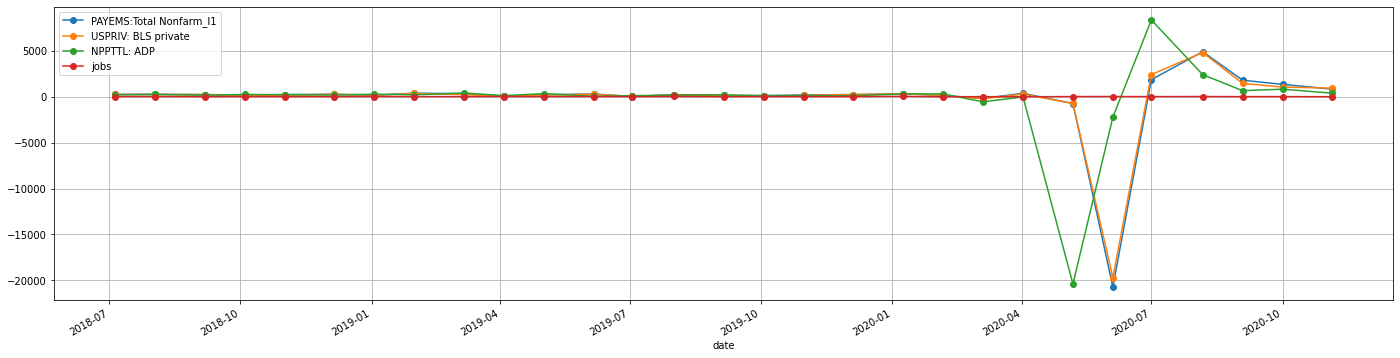

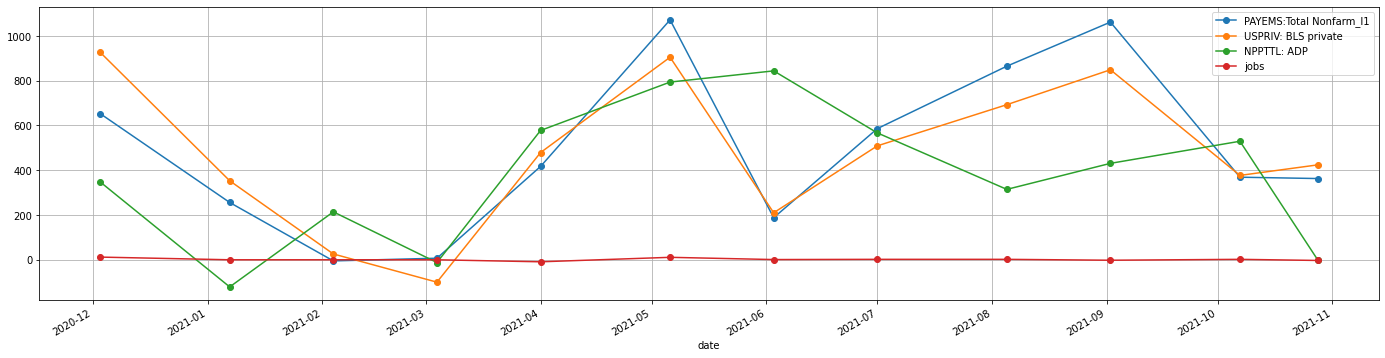

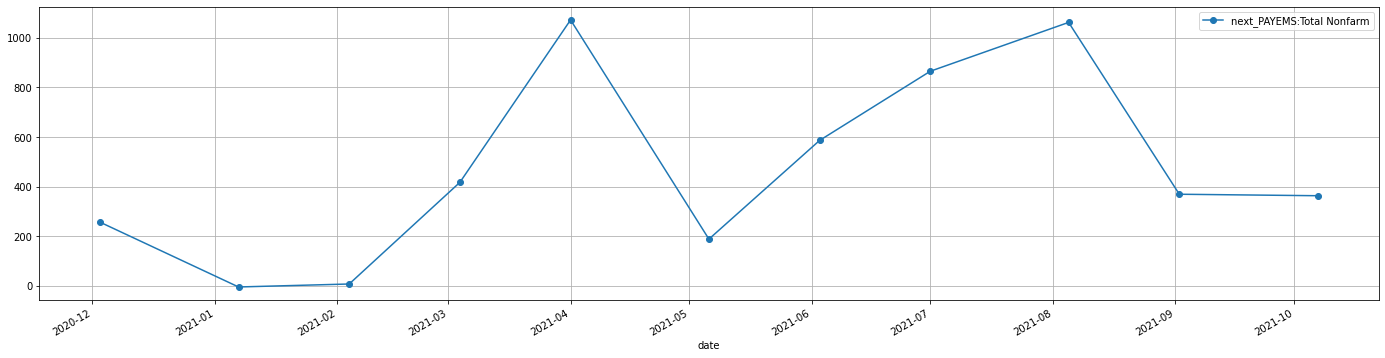

In [22]:
pcols = ["PAYEMS:Total Nonfarm_l1","USPRIV: BLS private", 'NPPTTL: ADP', 'jobs']
inds = xtrain.index > datetime.datetime(2018, 7, 1)
xtrain.loc[inds, pcols].plot(figsize=[24,6], grid=True, marker='o')
xtest[pcols].plot(figsize=[24,6], grid=True, marker='o')
ytestdf.plot(figsize=[24,6], grid=True, marker='o')

In [23]:
import sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, ElasticNet, Lasso, LassoCV, Ridge, SGDRegressor
from sklearn.svm import LinearSVR
 
rf = RandomForestRegressor(max_depth=4, random_state=0)
lr = LinearRegression()
en = ElasticNet(random_state=0, normalize=True)
gb = GradientBoostingRegressor()
svm = LinearSVR(random_state=0, max_iter=90000, tol=0.1, loss = 'squared_epsilon_insensitive', dual=False, verbose=2)
rr = Ridge()
lacv = LassoCV(normalize=True, n_alphas=10, max_iter=11000)
lacv = Lasso(normalize=True, alpha=10, max_iter=11000)
sgd = SGDRegressor()

mod = en
mod.fit(xtrain, ytraindf)
ytrain_hat = mod.predict(xtrain)

In [24]:
model_methods = [m for m in dir(mod) if not m.startswith("_")]
print("{0}".format(",".join(model_methods)))
if isinstance(mod,  RandomForestRegressor) or isinstance(mod, GradientBoostingRegressor):
  #fig, ax = plt.subplots( figsize=[10,24])
  #ax.barh(list(xtrain.columns), mod.feature_importances_,)  
  xx = zip(list(xtrain.columns), mod.feature_importances_)
  x = pd.DataFrame(xx, columns=["var", "imp"])
  x.sort_values(by='imp', ascending=False, inplace=True) 
  display(x.head(10))  
if isinstance(mod, LinearRegression):
  fig, ax = plt.subplots( figsize=[8,18])
  ax.barh(list(xtrain.columns), mod.coef_) 

if isinstance(mod, ElasticNetCV) or isinstance(mod, ElasticNet) or isinstance(mod, Ridge) \
    or isinstance(mod, Lasso) or isinstance(mod, LassoCV) or isinstance(mod, SGDRegressor) :
  xx = zip(list(xtrain.columns), mod.coef_)
  x = pd.DataFrame(xx, columns=["var", "coef"])
  x['abscoef'] = x['coef'].abs()
  x.sort_values(by='abscoef', ascending=False, inplace=True)
  display(x.head(10))

alpha,coef_,copy_X,dual_gap_,fit,fit_intercept,get_params,intercept_,l1_ratio,max_iter,n_features_in_,n_iter_,normalize,path,positive,precompute,predict,random_state,score,selection,set_params,sparse_coef_,tol,warm_start


,var,coef,abscoef
36,CIVPART: Civilian Participation Rate,49.347440,49.347440
48,Expected Index,9.229841,9.229841
44,BSCICP03USM665S: OECD Business Confidence,8.044435,8.044435
47,Business Condition 5 Years,5.236686,5.236686
46,Business Condition 12 Months,3.841121,3.841121
7,amazon jobs work from home,3.656256,3.656256
19,jobs work from home,3.544028,3.544028
12,work from home jobs,3.544021,3.544021
26,work from home amazon,3.102729,3.102729
22,work from home,2.276162,2.276162


(12, 52) (12,) (12,)


<AxesSubplot:xlabel='date'>

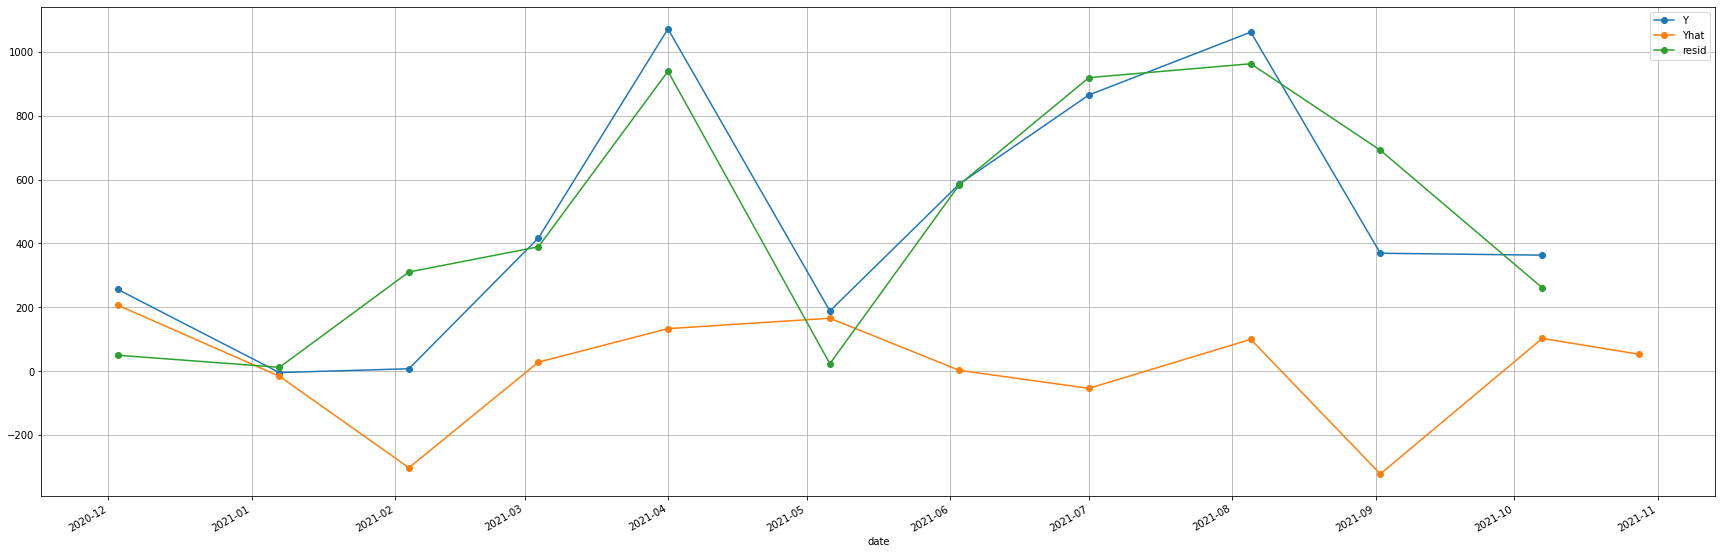

In [25]:
ytest_hat = mod.predict(xtest)

print(xtest.shape, ytest.shape, ytest_hat.shape)
zz = pd.DataFrame(data = {"Y":ytest, "Yhat":ytest_hat}, index=testdf.index)
zz['resid'] = zz['Y'] - zz['Yhat']
zz.plot(figsize = [30,10], marker = 'o', grid=True,)

In [26]:
#  what is this for??
if False:
  nrows=1
  ncols=1
  figwd=20
  fight=10
  sharex=True
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[figwd, fight], sharex=sharex)
  print(axs)
  ax = axs
  diffdf.tail(20).reset_index().plot(ax=ax,  y=ycol, figsize=[20,10], marker='o',
                            mec='red', mfc='black', ms=0.75, grid=True)
  ax.axhline(y=0)

(18, 3)


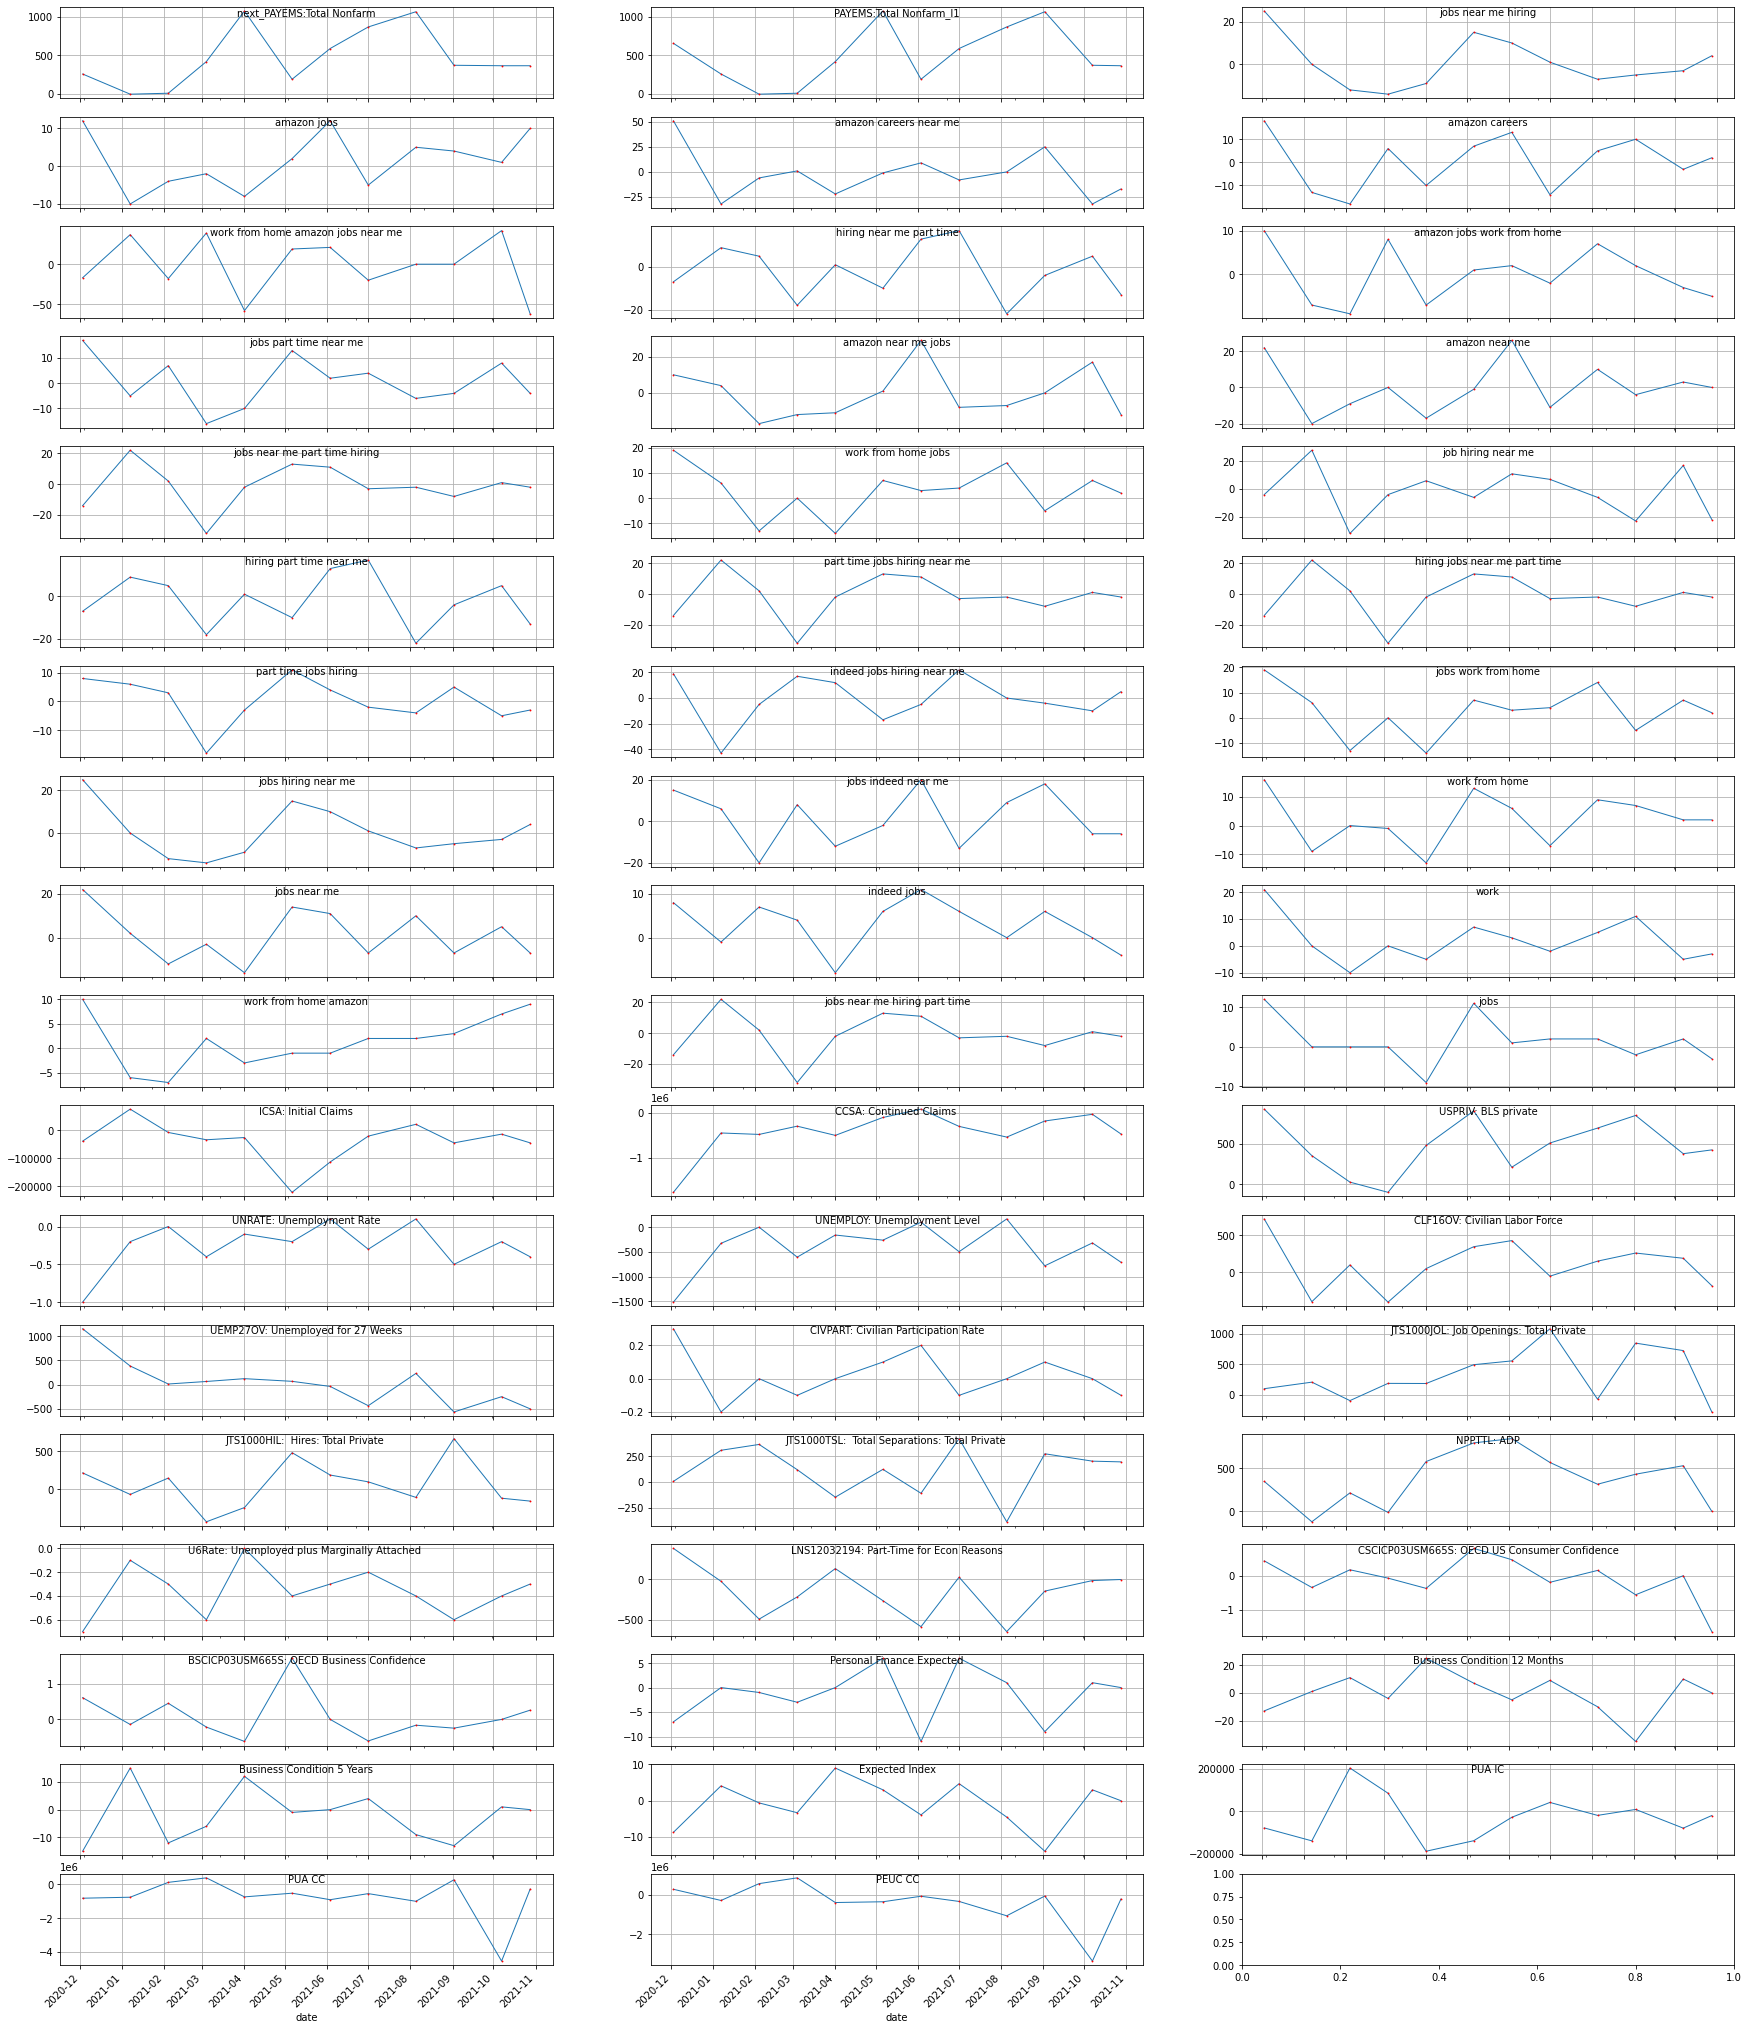

In [27]:
xcol = "date"
title = "title"
temp_df = testdf.loc[testdf.index > '2019-12-01'].copy()
temp_df.bfill(inplace=True)
temp_df.ffill(inplace=True)
temp_df.fillna(0, inplace=True)
temp_df.reset_index(inplace=True)

ycols = [c for c in temp_df.columns if c != "date"]

sharex = False
ncols=3
figwd=30
fight=40
xtick_rot = 45
ylim=(None, None)
nrows = int(np.ceil(len(ycols)/float(ncols)))
fig = None
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[figwd, fight], sharex=sharex)  
print(axs.shape)
for i, ycol in enumerate(ycols):
  if ycol == "date":
    continue
  row = i // ncols
  col = i % ncols
  ax = axs[row][col]  
  #print(ycol)
  temp_df.plot(ax=ax, kind='line', x=xcol, y=ycol,linestyle='-', marker='o', lw=1, ylim=ylim,
                   mec='red', mfc='black', ms=0.85,  title=None, legend=None, label=None, grid=True, sharex=True)

  ax.text(.5,.9, ycol,
        horizontalalignment='center',
        transform=ax.transAxes)  
    
  ax.xaxis.set_tick_params(rotation=xtick_rot)     

plt.show()

In [28]:
print(*zip(ytest_hat, ytest))

(206.5964927250194, 256.0) (-16.515790813088735, -5.0) (-303.22026193321125, 7.0) (27.736455882751535, 417.0) (132.71164595283042, 1072.0) (165.2745592576338, 188.0) (2.0005244795217934, 586.0) (-54.36926686352379, 865.0) (99.19107122966338, 1062.0) (-322.8848431857854, 369.0) (102.15576526488036, 363.0) (52.317359414975506, nan)
